# Análisis de Series Temporales
## Primer Trabajo

#### Autores
 * TODO

In [1]:
rm(list = ls())
options(repr.plot.width=10, repr.plot.height=6)

In [2]:
library(magrittr)
library(dplyr, warn.conflicts = FALSE)
library(ggplot2)
library(latex2exp)
require(reshape2)
library(forecast)

Loading required package: reshape2


In [3]:
lags <- 32

In [4]:
range_mean <- function(x, seasonality = 12) {
    n <- length(x)
    seq(1, n, by=seasonality) %>%
    sapply(function(i){
        a <- x[i:(i+seasonality)]
        c(mean=mean(a, na.rm=TRUE), range=diff(range(a,na.rm=TRUE)))
    }) %>%
    t() %>%
    as.data.frame()
} 

In [5]:
correlogram <- function(x, n = length(x) - 1, with.first = FALSE) {
    result <- acf(x, lag.max=n, plot=FALSE)$acf[1:n + !with.first]
    data.frame(lag = 1:length(result), values = result)
}

In [6]:
periodogram <- function(x) {
    result <- TSA::periodogram(x, plot=FALSE)
    data.frame(freq = c(0, result$freq), spec = c(0, result$spec))
}

In [7]:
plot.serie <- function(df, stationality, armonics = c()){
    p.a <- ggplot(df) + 
        aes(x = index, y = values) + 
        geom_line() 

    p.b <- ggplot(range_mean(df$values, stationality)) + 
        aes(x = mean, y = range) + 
        geom_point(size=3) + 
        expand_limits(y=0)

    p.c <- ggplot(correlogram(df$values, lags)) + 
        aes(x = lag, y = values) + 
        geom_bar(stat="identity") +
        geom_hline(yintercept = 2/sqrt(nrow(df)), color = "red") +
        geom_hline(yintercept = -2/sqrt(nrow(df)), color = "red")

    p.d <- ggplot(periodogram(df$values)) + 
        aes(x = freq, y = spec) + 
        geom_line()
    
    for (a in armonics) {
        p.d <- p.d + geom_vline(xintercept = a, color = "red", alpha = 0.4)
    }
    cowplot::plot_grid(p.a, p.b, p.c, p.d)
}

# Sea $\{Y_t\}$ un proceso estacionario con media cero, sean $a$ y $b$ constantes.

En este caso se van a realizar distintas simulaciones para series temporales. Dichas series estarán compuestas por ciertas constantes, las cuales se indican a continuación:

In [8]:
a <- 2
b <- 0.25
sigma <- 2
n <- 204

In [9]:
data.frame(Variable = "Valor", a = a, b = b, sigma = sigma, n = n)

Variable,a,b,sigma,n
Valor,2,0.25,2,204


## Sea $X_t = a + b \cdot t + s_t + Y_t$ donde $s_t$ es una componente estacional con periodo $12$. Simular $204$ datos para $X_t$. Hacer el plot de la serie, el plot rango-media, el correlograma y el periodograma.

Para esta serie es necesario determinar los coeficientes estacionales (en este caso $12$). Puesto que la serie será de carácter aditivo, vamos a imponer la restricción de que todos ellos sumen $0$. Los valores escogidos son los siguientes:

In [10]:
s.a <- c(1, 2, 3, 4, 5, 6, -6, -5, -4, -3, -2, -1)
y.a <- rnorm(n, sd = sigma)
x.a <- a + b * (1:n) + rep(s.a, length.out=n) + y.a
df.a <- data.frame(index = 1:length(x.a), values = x.a)

In [11]:
data.frame("Retardo" = 1:12, "Coef Estacional" = s.a) %>%
    mutate_if(is.numeric, round, digits = 4) %>%
    mutate_all(as.character) %>% 
    t()

Retardo,1,2,3,4,5,6,7,8,9,10,11,12
Coef.Estacional,1,2,3,4,5,6,-6,-5,-4,-3,-2,-1


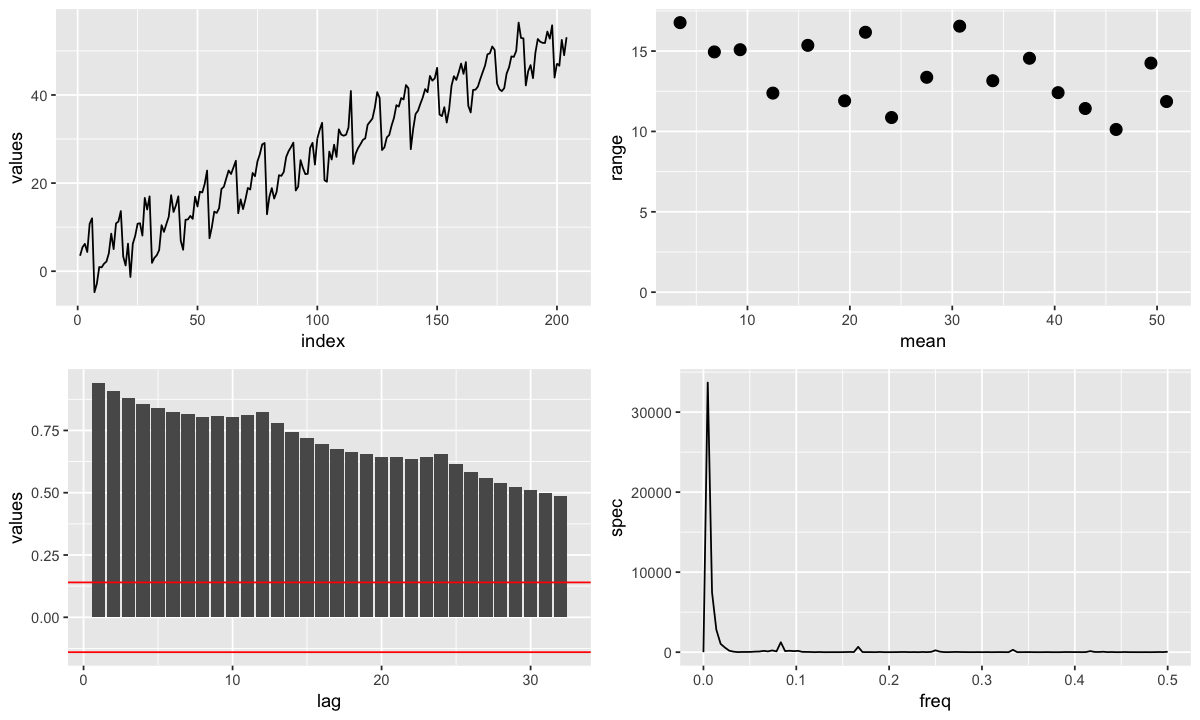

In [12]:
plot.serie(df.a, stationality = 12)

A continuación se analizan los gráficos generados. En el caso del gráfico de la serie, se puede apreciar una marcada tendencia creciente (lo cual era de esperar dadas las constantes escogidas). También se puede apreciar la estructura estacional escogida, con un gran decrecimiento repentino en la zona intermedia de cada periodo. 

En cuanto al gráfico de dispersión *rango-media*, debido al modelo aditivo subyacente, no se aprecia correlación entre el la media y el rango por lo que podemos asumir una varianza constante. 

Para el caso del correlograma, se puede apreciar la estacionalidad de la serie, con pequeños escalones de periodo $12$. Debido al decrecimiento que se muestra en la misma, podemos afirmar que no es estacionaria (se había construido para que no lo fuera).

En cuanto al periodograma, este refleja una fuerte correlación con el primer retardo. Se cree que esto es algo debido a la fuerte tendencia creciente, que oculta la estacionalidad (se comprobará que es cierto cuando se realicen las pertinentes diferenciaciones de la serie).

## Sea $X_t =(a + b \cdot t) \cdot s_t + Y_t$ donde $s_t$ es otra vez una componente estacional con periodo $12$. Simular $n = 204$ datos para $X_t$. Hacer el plot de la serie, el plot rango-media, el correlograma y el periodograma.

Para esta serie es necesario determinar los coeficientes estacionales (en este caso $12$). Puesto que la serie será de carácter multiplicativo, vamos a imponer la restricción de que todos ellos sumen $12$. Los valores escogidos son los siguientes:

In [13]:
s.b <- c(1, -2, 3, 4, 5, 6, 1/6, -1/5, 1/4, 1/3, 1/2, 1) * 12
y.b <- rnorm(n, sd = sigma)
x.b <- (a + b * (1:n)) * rep(s.b, length.out=n) + y.a
df.b <- data.frame(index = 1:length(x.b), values = x.b)

In [14]:
data.frame("Retardo" = 1:12, "Coef Estacional" = s.b) %>%
    mutate_if(is.numeric, round, digits = 3) %>%
    mutate_all(as.character) %>% 
    t()

Retardo,1,2,3,4,5,6,7,8,9,10,11,12
Coef.Estacional,12,-24,36,48,60,72,2,-2.4,3,4,6,12


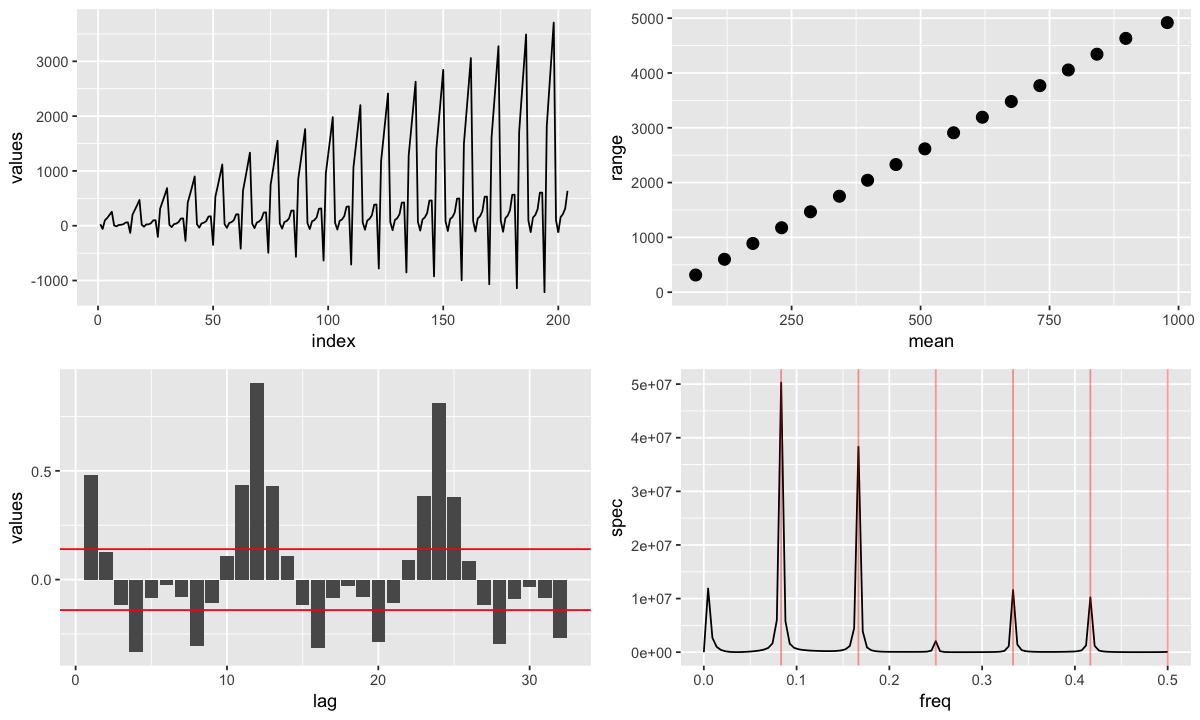

In [15]:
plot.serie(df.b, stationality = 12, armonics = 1:6/12)

A continuación se analizan los gráficos generados. En el caso del gráfico de la serie, se puede apreciar que en este caso no hay tendencia, lo cual era esperable por la estructura del modelo subyacente. También se puede apreciar la estructura estacional escogida, con un gran decrecimiento repentino en la zona intermedia de cada periodo. 

En cuanto al gráfico de dispersión *rango-media*, debido al modelo multiplicativo subyacente, se aprecia una elevada correlación entre el la media y el rango, por tanto podemos afirmar que esta es variable respecto del eje de abscisas. 

Para el caso del correlograma, se aprecia una marcada estacionalidad de la serie, con escalones de periodo $12$. Debido al decrecimiento lineal que se muestra en la misma, podemos afirmar que no es estacionaria (se había construido para que no lo fuera).

En cuanto al periodograma, este refleja una marcada estacionalidad determinista de periodo 12. Esto es algo esperable debido a la construcción de la serie. Dado que en este caso, na serie no tiene tendencia, hemos podido apreciarla sin tener que realizar diferenciaciones.

## Para las series obtenidas en los apartados anteriores, tomar las siguientes diferenciaciones: $\nabla X_t$, $\nabla_{12} X_t$, $\nabla \nabla_{12} X_t$, $\nabla^{2}_{12} X_t$) y comentar el efecto que éstas producen adjuntando los gráficos necesarios.

A continuación se desarrollan las diferenciaciones para tratar de poder comprender mejor su actuación sobre la serie de partida:

* Diferenciación Regular:

\begin{align*}
  \nabla X_t 
  &= (1 - B) X_t \\
  &= X_t - X_{t-1}
\end{align*}

In [16]:
dif_1 <- function(x) {
    d <- diff(x, lag = 1)
    data.frame(index = 1:length(d), values = d)
}

* Diferenciación Estacional (periodo 12)

\begin{align*}
  \nabla_{12} X_t 
  &= (1 - B^{12}) X_t \\
  &= X_t - X_{t-12}
\end{align*}

In [17]:
dif_12 <- function(x) {
    d <- diff(x, lag = 12)
    data.frame(index = 1:length(d), values = d)
}

* Diferenciación Estacional (periodo 12) con un retardo regular

 
\begin{align*}
  \nabla \nabla_{12} X_t  
  &= (1 - B)(1 - B^{12}) X_t \\
  &= (1 - B) (X_t - X_{t-12}) \\
  &= X_t - X_{t-1} - X_{t-12} + X_{t-13}
\end{align*}

In [18]:
dif_1_12 <- function(x) {
    d <- diff(diff(x, lag = 12), lag = 1)
    data.frame(index = 1:length(d), values = d)
} 

* Diferenciación Estacional (periodo 12) con dos diferenciaciones:

\begin{align*}
  \nabla^{2}_{12} X_t 
  &= (1 - B^{12})^{2} X_t \\
  & = (1 - B^{12})(1 - B^{12}) X_t \\
  &= X_t - 2 \cdot X_{t-12}+X_{t-24}
\end{align*}

In [19]:
dif_12_12 <- function(x) {
    d <- diff(x, lag = 12, differences = 2)
    data.frame(index = 1:length(d), values = d)
}

### Modelo Aditivo

A continuación se muestran los gráficos de la serie simuladada perteneciente a un modelo de carácter aditivo con una diferenciación de un retardo (regular):

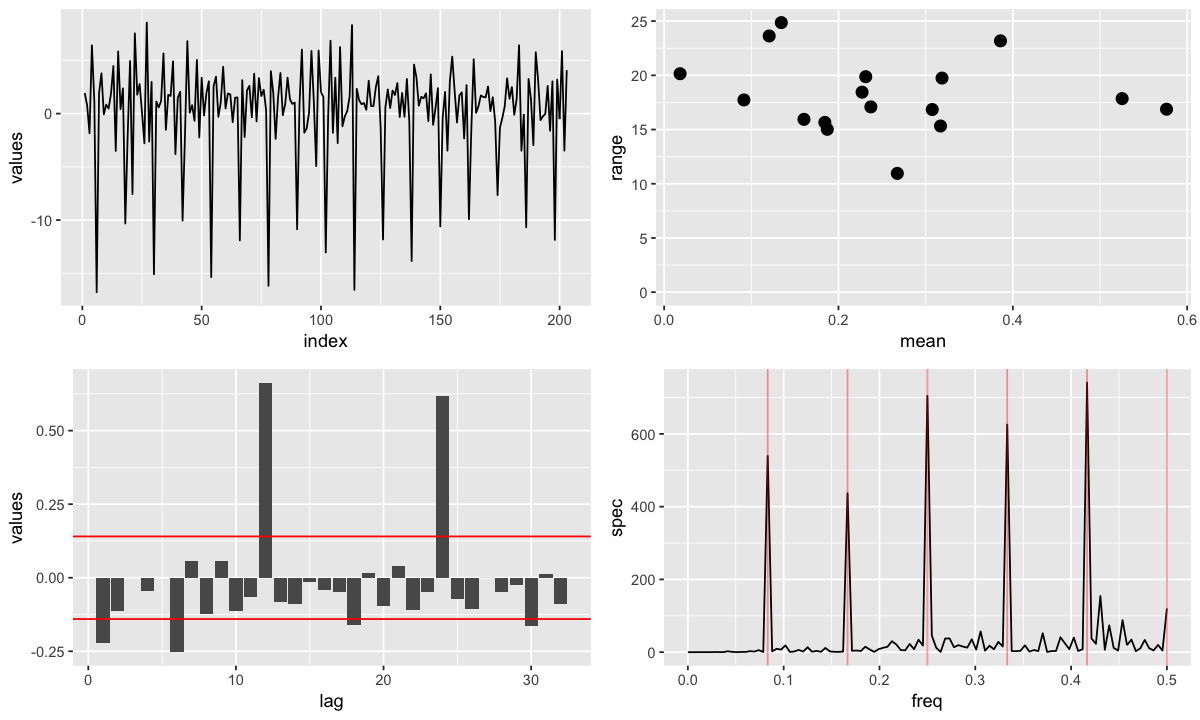

In [20]:
plot.serie(dif_1(x.a), stationality = 12, armonics = 1:6/12)

Gracias a la primera diferenciación se consigue eliminar la tendencia (en el plot de la serie se puede ver como ya no un patrón claro de crecimiento o decrecimiento). Sigue estando, presente, sin embargo, la estacionalidad, pues el correlograma indica autocorrelación alta en los retardos 12 y 24 (múltiplos del período, 12).

A continuación se muestran los gráficos de la serie simuladada perteneciente a un modelo de carácter aditivo con una diferenciación de 12 retardos (estacional):

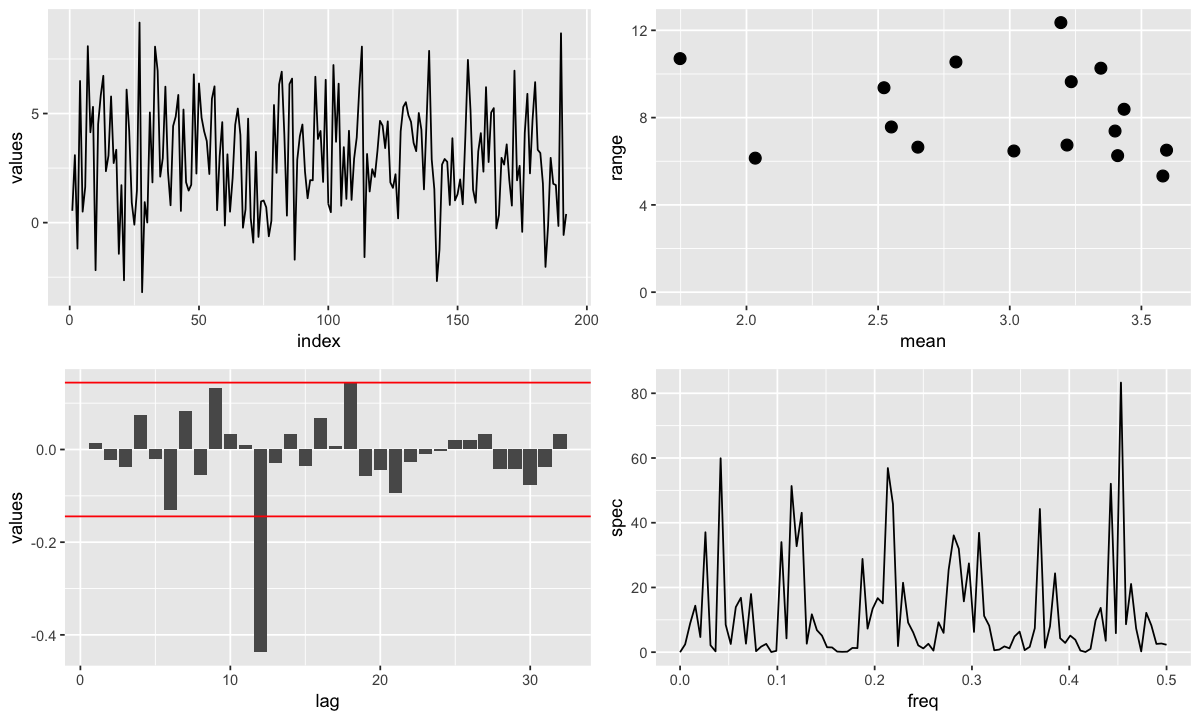

In [21]:
plot.serie(dif_12(x.a), stationality = 12)

Con la segunda diferenciación (12 retardos) se consigue eliminar la tendencia y parcialmente la estacionalidad. La explicación de la tendencia es la misma que para la diferenciación anterior (además, el correlograma no presenta el decrecimiento exponencial característico de la estacionaridad). La estacionalidad no desaparece por completo, puesto que la barra del retardo 12 muestra una autocorrelación alta.

Las dos diferenciaciones siguientes consiguen unos efectos muy similares a la anterior, por lo que la segunda es la más adecuada atendiendo al criterio de mínima diferenciación que elimina tendencia y/o estacionalidad.

A continuación se muestran los gráficos de la serie simuladada perteneciente a un modelo de carácter aditivo con una diferenciación compuesta de 12 retardos (estacional) y 1 retardo (regular):

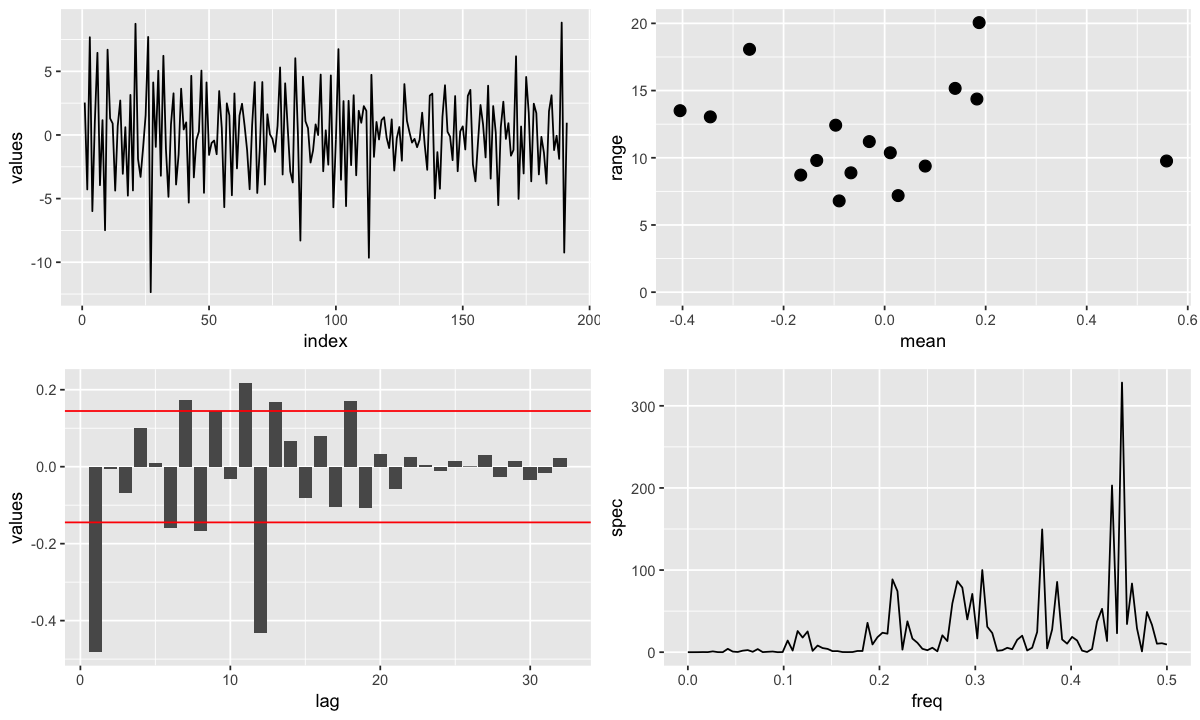

In [22]:
plot.serie(dif_1_12(x.a), stationality = 12)

A continuación se muestran los gráficos de la serie simuladada perteneciente a un modelo de carácter aditivo con 2 diferenciaciones de 12 retardos (estacional):

In [23]:
x.a.dif_12_12 <- dif_12_12(x.a)

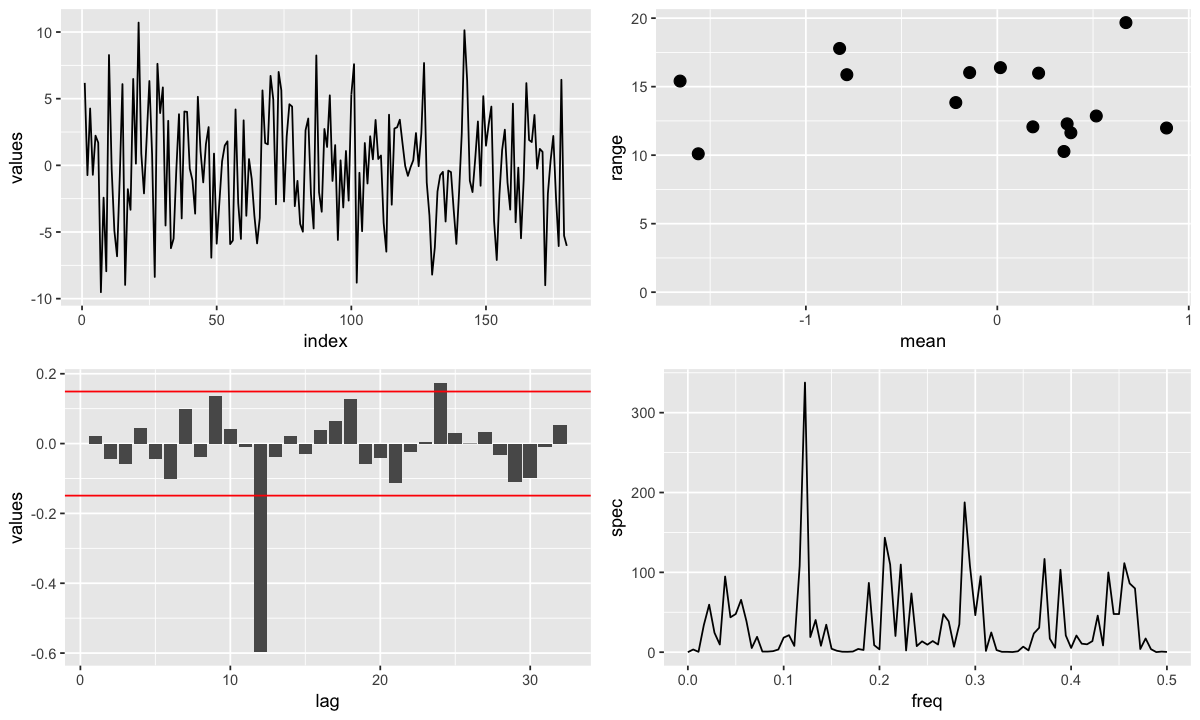

In [24]:
plot.serie(x.a.dif_12_12, stationality = 12)

### Modelo Multiplicativo

A continuación se muestran los gráficos de la serie simuladada perteneciente a un modelo de carácter multiplicativo con una diferenciación de un retardo (regular):

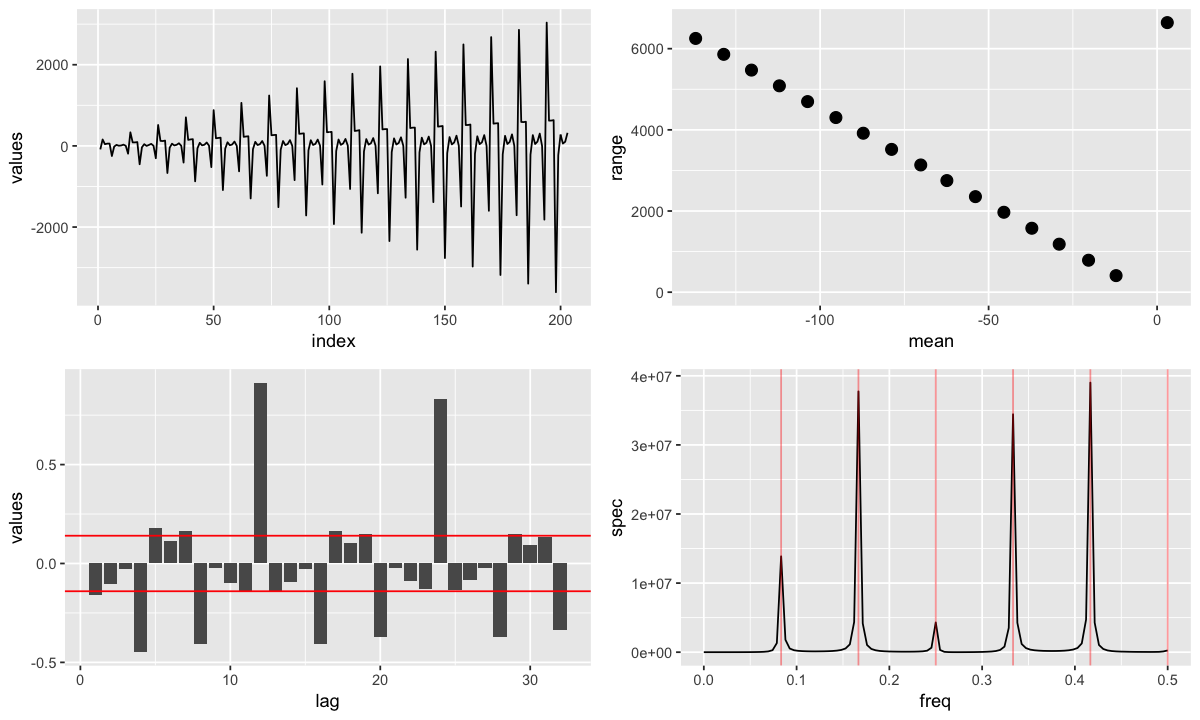

In [25]:
plot.serie(dif_1(x.b), stationality = 12, armonics = 1:6/12)

Con la primera diferenciación se elimina la tendencia. La estacionalidad sigue presente (barras 12 y 24 muestran alta autocorrelación; apreciable también en el periodograma en las frecuencias 1/12 = 0.083,  2/12 = 0.167, etc. que recogen mucha varianza).

A continuación se muestran los gráficos de la serie simuladada perteneciente a un modelo de carácter multiplicativo con una diferenciación de 12 retardos (estacional):

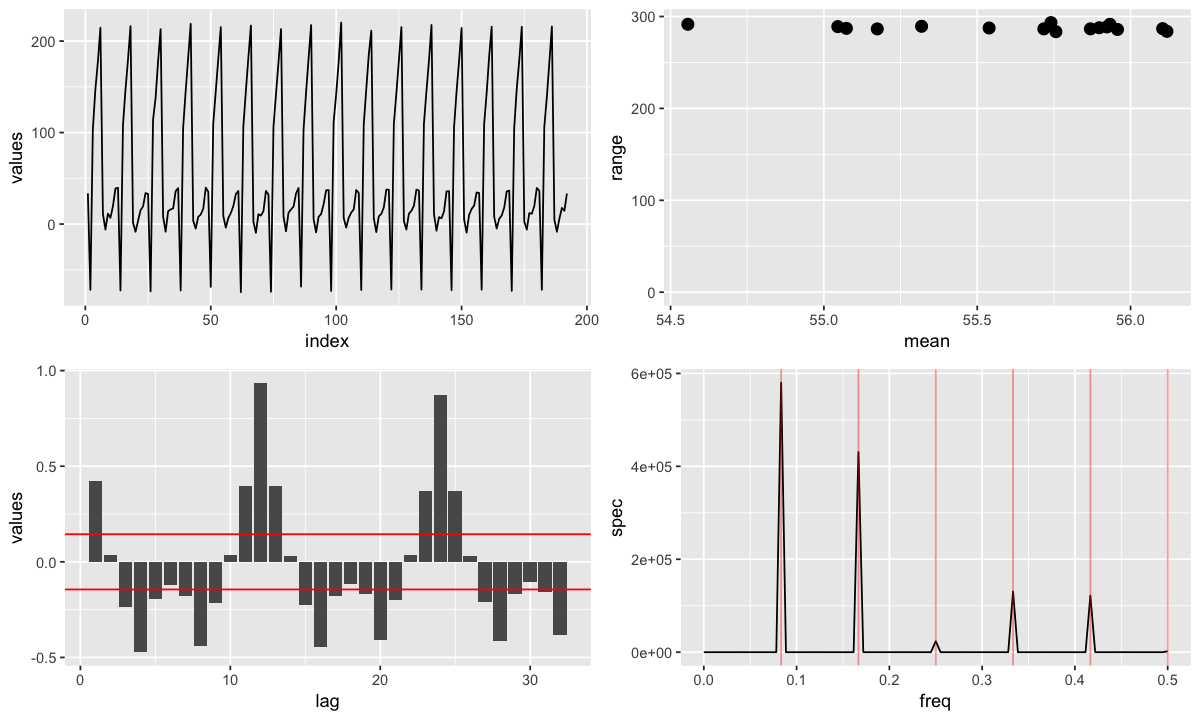

In [26]:
plot.serie(dif_12(x.b), stationality = 12,armonics = 1:6/12)

Con el resto de diferenciaciones también se elimina la tendencia. Ni la segunda ni la tercera diferenciación consiguen eliminar la estacionalidad (las barras 12 y 24 aparecen muy destacadas en los correlogramas).

Al igual que en el modelo aditivo, no se consigue eliminar completamente la estacionalidad con ninguna diferenciación. Sin embargo, la cuarta diferenciación la elimina parcialmente (se conserva la autocorrelación alta en el retardo 12).

A continuación se muestran los gráficos de la serie simuladada perteneciente a un modelo de carácter aditivo con una diferenciación compuesta de 12 retardos (estacional) y 1 retardo (regular):

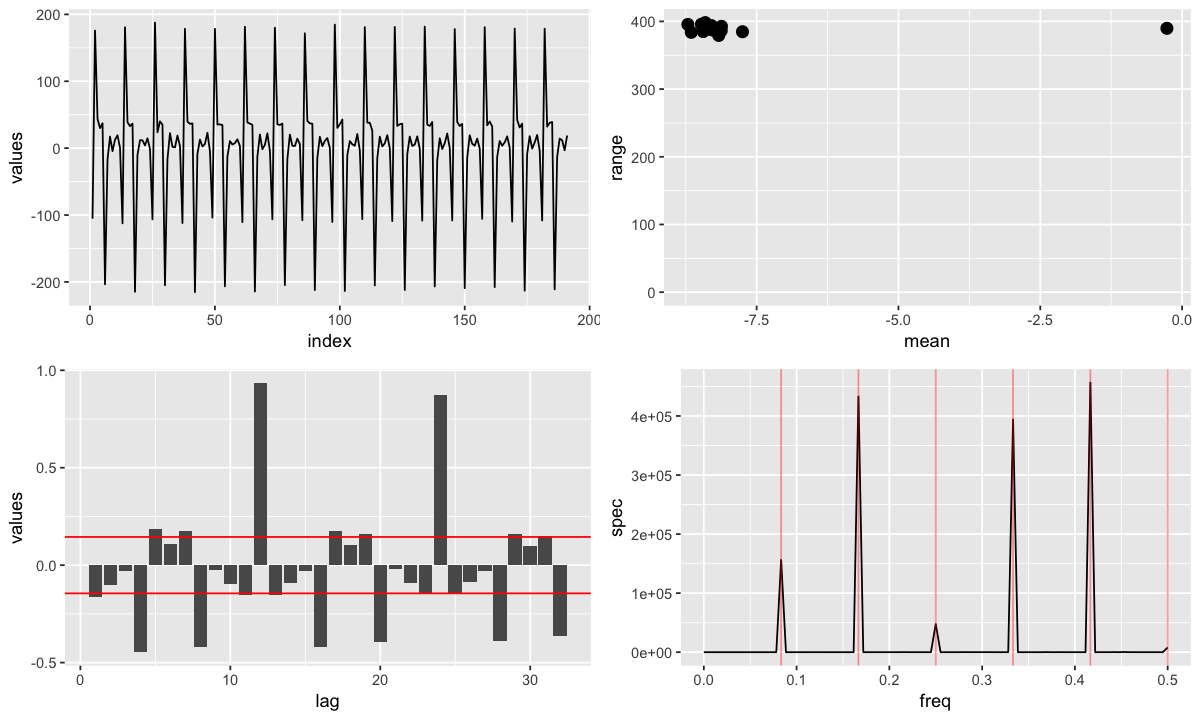

In [27]:
plot.serie(dif_1_12(x.b), stationality = 12,armonics = 1:6/12)

En este caso, el plot rango media presenta un *outlier* que creemos que se debe a las los puntos de partición, que dejan uno de ellos descompensado respecto del resto, ya que $(204 - 13) \ mod \ 12 \neq 0$.

A continuación se muestran los gráficos de la serie simuladada perteneciente a un modelo de carácter multiplicativo con 2 diferenciaciones de 12 retardos (estacional):

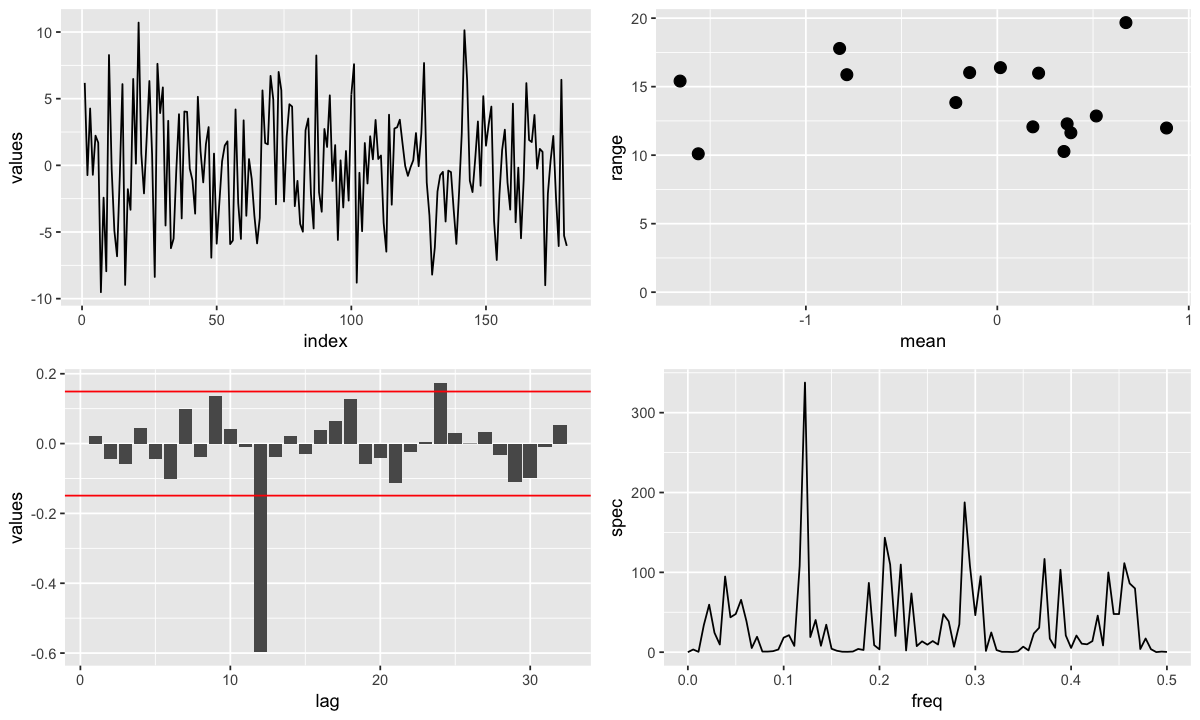

In [28]:
plot.serie(dif_12_12(x.b), stationality = 12)

# Localización archivos de datos: Carpeta *datos* para T1 en el tema 2 del Campus Virtual.

## Describir la serie (plot de la serie, observaciones atípicas, plot rango-media, periodograma de la serie y de la diferenciada regularmente, correlograma de la serie y de la diferenciada regularmente, seasonal subseries plot, cualquier gráfico que ayude a entender la serie).

In [29]:
activos <- read.csv("./../data/activos.csv")
colnames(activos) <- c("values")
activos$index <- seq(as.Date("1976/10/01"), by = "3 months", 
                     length.out = nrow(activos))

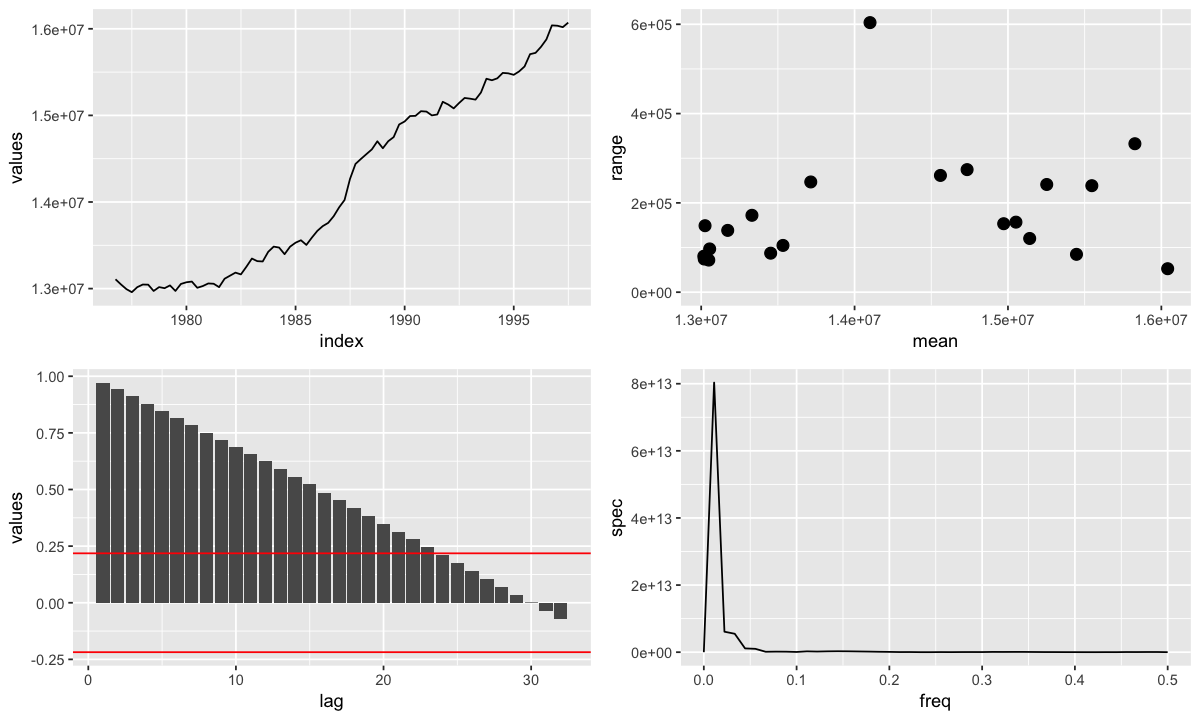

In [30]:
plot.serie(activos, stationality = 4)

Tal y como se puede apreciar, en el gráfico de la serie se observa una tendencia creciente, así como que los datos no han sido generados aleatoriamente (ruido blanco) ya que está tiene una fuerte tendencia creciente.

El gráfico de dispersión de la variable rango respecto de la media (agrupada en grupos de tamaño $4$). Esta representación se utiliza para ver si existe alguna relación entre media y rango, (analizar si la varianza crece con la media). A la vista del grafico no se observa ninguna relación entre la media y la varianza, no obstante, no se descarta la posibilidad de hacer alguna transformación.

En cuanto al correlograma, este un decrecimiento no exponencial (claramente lineal), y por lo que no puede ser considerada una distribución estacionaria. Al igual que intuíamos al ver el gráfico de la serie, en este que no hay ruido blanco, al observar que las primeras correlaciones están todas ella por fuera de la banda de confianza de ruido blanco. No es fácil interpretar la estacionalidad ya que no sobresale niguna correlacion respecto del resto (Probablemente la tendencia oculta dicha estacionalidad). 

Tras observar el el gráfico del periodograma observamos una tendencia fuerte, pues la primera frecuencia de Fourier tiene una ordenada muy alta (el valor 1/n explica mucha variabilidad). La tendencia es tan alta que tal vez este ocultando la posible estacionalidad, tal y como comentamos en el correlograma, así que procederemos a diferenciar la serie para eliminar dicha tendencia. 

## Diferenciar la serie regular y/o estacionalmente hasta conseguir estacionaridad en la diferenciada.

Debido a la dificultad para poder interpretar el comportamiento de la serie en cuestión, que queda ocultado por la fuerte tendencia de la misma, vamos a proceder a reducir dicha problemática. Para ello, vamos a diferenciar la serie regularmente. Es decir, aplicaremos el filtro $\nabla X_t$. De esta manera esperamos poder recabar mayor información acerca de la estacionalidad de la serie.

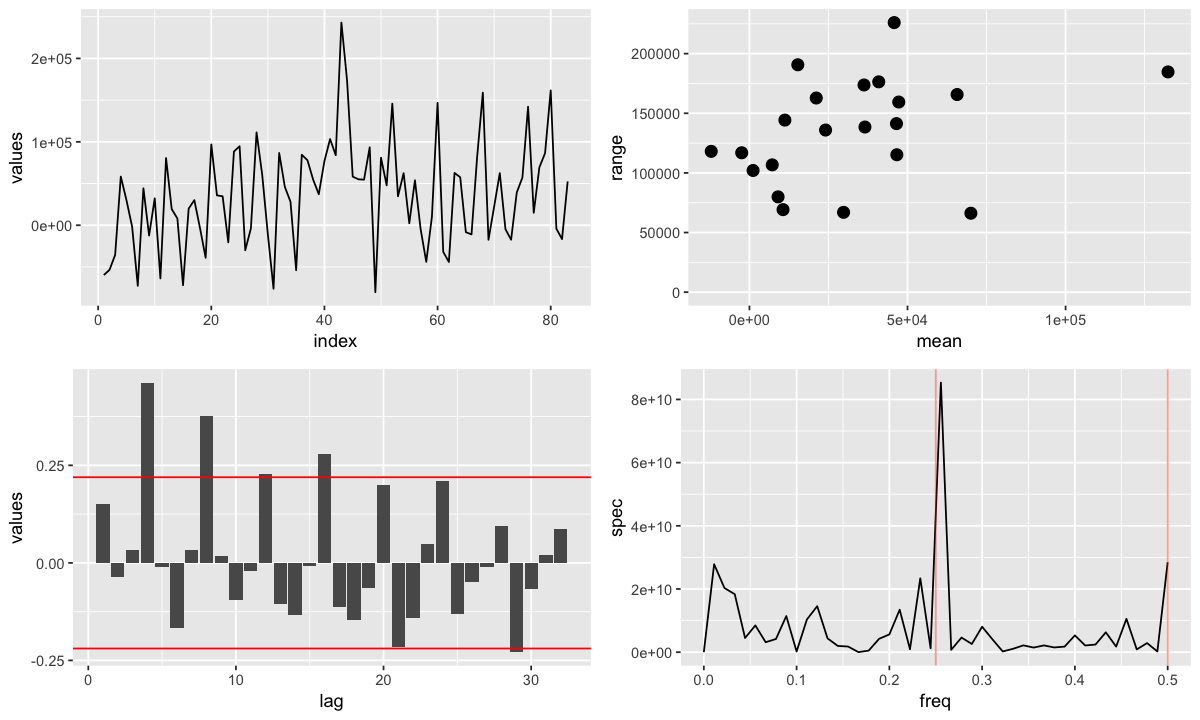

In [31]:
plot.serie(dif_1(activos$values), stationality = 4, armonics = 1:2/4)

En las figuras superiores se muestran el gráfico de la serie, el diagrama de dispersión *rango-media*, el correlograma y el periodograma respectivamente. Por tanto, a continuación procederemos a dar una interpretación a los mismos.

Al observar el grafico de la serie diferenciada podría pensarse que es ruido blanco por la aparente aleatoriedad de las observaciones. Sin embargo, observamos un salto en la zona intermedia, así como una ligera tendencia creciente. Dicho salto podría deberse a un outlier, por lo sería interesante hacer un análisis complementario de la serie obviando dicha observación. Sin embargo, en este caso únicamente nos hemos centrado en estudiar la razón del mismo: Se puede comprobar que la observación se corresponde con el segundo trimestre de $1987$. En dicho año, hubo un cambio en la legislación sobre las condiciones de trabajo y participación de personal en actividades públicas, recogida en el BOE en este articulo: https://www.boe.es/buscar/pdf/1987/BOE-A-1987-14115-consolidado.pdf


En cuanto al diagrama de dispersión *rango-media* seguimos apreciando una distribución uniforme de los pares, lo cual nos hace pensar que no existe correlación entre media y varianza, algo que es deseable en el análisis de series (y que sino deberíamos tratar de corregir con transformaciones).

En cuanto al correlograma, ahora si que se ve una marcada estacionalidad al estudiar el correlograma de la serie, observando correlaciones periódicas de periodo 4, que decrecen de manera lineal. Esto nos indica que la serie presenta una estacionalidad de periodo $4$, por tanto, posteriormente diferenciaremos la serie respecto de este retardo para conseguir desestacionarla completamente.

En cuanto al periodograma, se puede apreciar que el armónico $\frac{1}{4}$ destaca claramente respecto del resto, lo cual se ve reflejado en el armónico $\frac{1}{2}$. Esto confirma que la serie presenta una tendencia de periodo $4$. En cuanto al tipo de periodo de esta serie, se cree que es de tipo determinista, ya que se observan los armónicos significativos muy marcados en valores concretos. En caso contrario, diríamos que es estocástica.

* Diferenciación Estacional (periodo 4)

\begin{align*}
  \nabla_{4} X_t 
  &= (1 - B^{4}) X_t \\
  &= X_t - X_{t-4}
\end{align*}

In [32]:
dif_4 <- function(x) {
    d <- diff(x, lag = 4)
    data.frame(index = 1:length(d), values = d)
}

A continuación se muestran distintos gráficos de la serie diferenciada respecto del cuarto retardo, es decir, $\nabla X_t$. Estos gráficos se corresponden con el gráfico de la serie, el gráfico de dispersión *rango-media*, el correlograma y el periodograma. A continuación se trata de dar una interpretación acerca de los mismos.

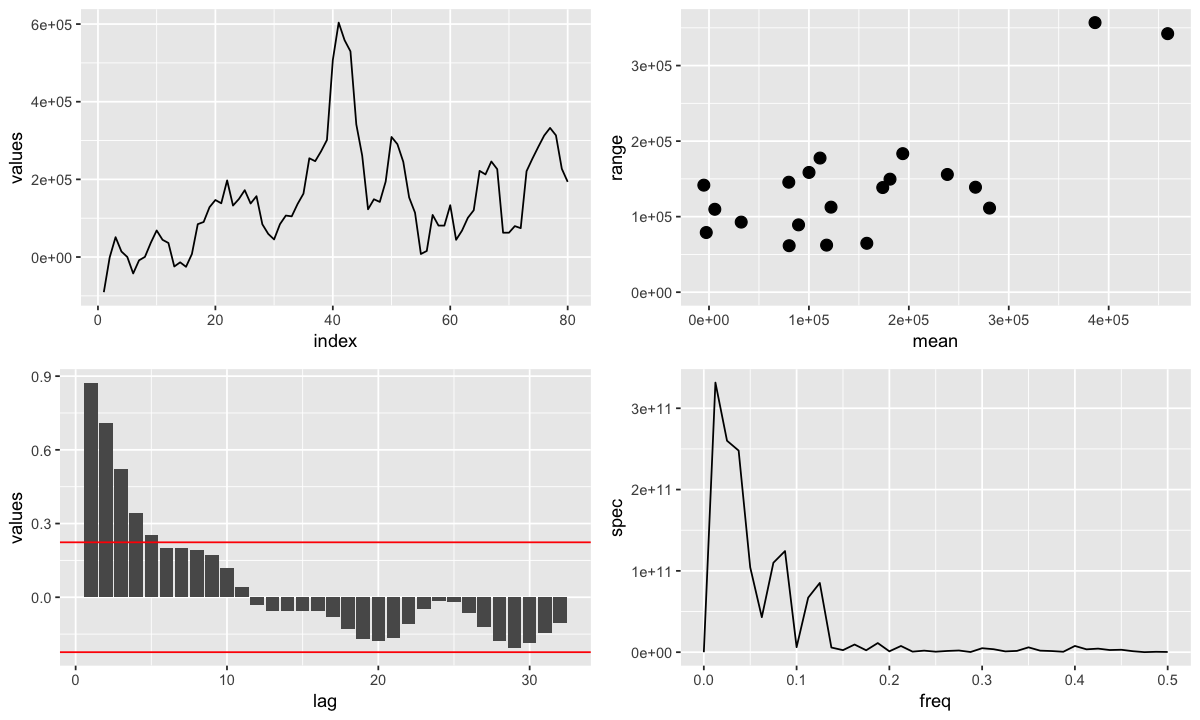

In [33]:
activos.dif_4 <- dif_4(activos$values)
plot.serie(activos.dif_4, stationality = 4)

En el gráfico de la serie se puede observar que esta presenta tendencia creciente, que no podemos considerar como ruido blanco (a continuación se da una justificación). Se sigue observando un pico en el grafico pero esta vez no es debido a una sola observación, sino que son cuatro las implicadas (correspondientes a un ciclo anual).

En cuanto al correlograma, en este se puede apreciar un decrecimiento rápido (de carácter exponencial) en las autocorrelaciones. Esto indica por tanto que hemos conseguido llegar a la estacionaridad de la serie.

Esto se ve reflejado en el periodograma, ya que se observa un alto valor en la primera frecuencia de Fourier. La interpretación de esto es que el armónico $1/n$ explica mucha variabilidad.

## Ajustar una curva por mínimos cuadrados a la serie desestacionalizada para modelizar la tendencia. Representar la ACF y periodograma de los residuales y comentar lo que se observa en los gráficos.

Para el ajuste de la serie por mínimos cuadrados, se ha escogido, un modelo lineal polinómico de grado $3$:
$$E\left[Y\right] = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3$$

Sin embargo, tal y como se puede apreciar en el siguiente gráfico, en el que se muestra la estimación sobre los datos observados, este no consigue recoger gran parte de la variabilidad de la serie. 

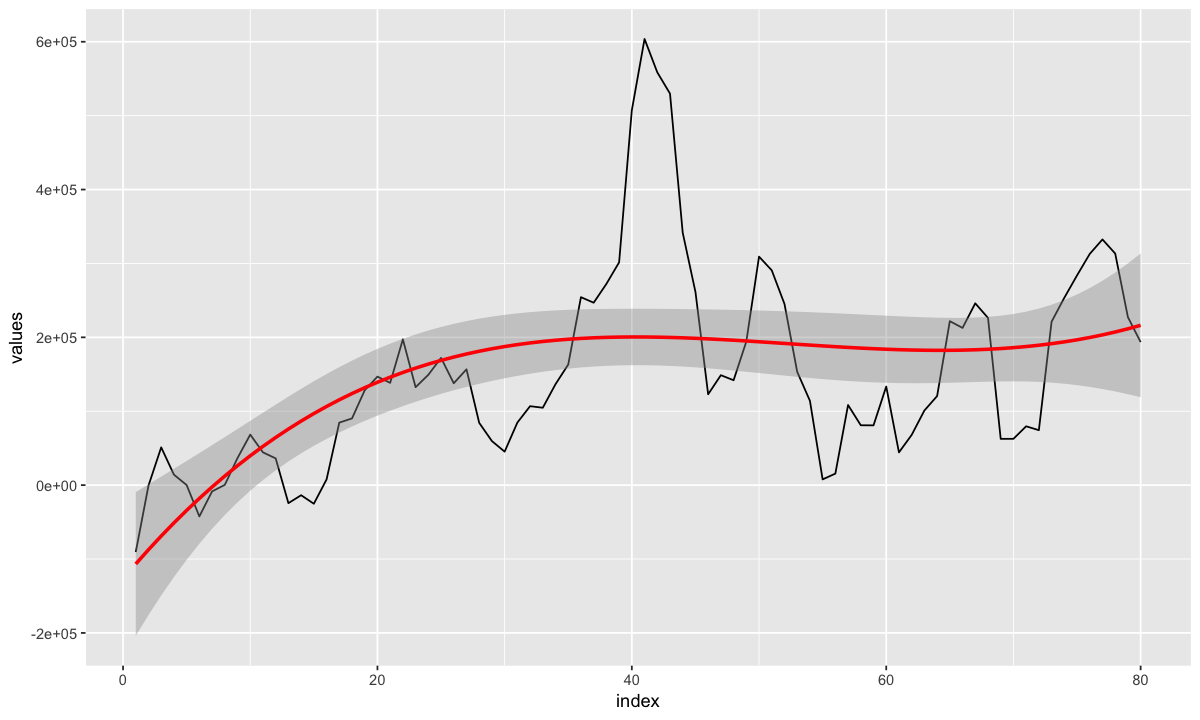

In [34]:
ggplot(activos.dif_4) + 
    aes(x = index, y = values) + 
    geom_line() + 
    geom_smooth(method="lm", formula=y ~ poly(x, 3), level = 0.95, color = "red")

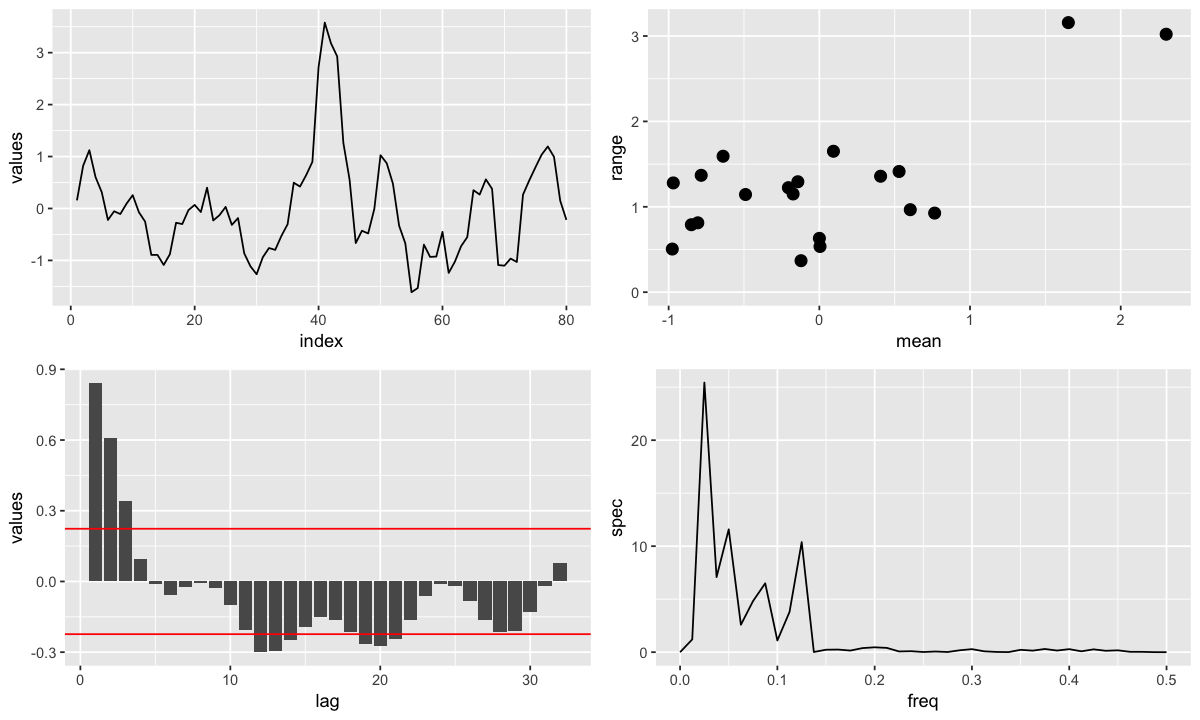

In [35]:
activos.dif_4.model <- lm(values ~ poly(index, 3), data = activos.dif_4)
activos.dif_4.model.p <- activos.dif_4
activos.dif_4.model.p$values <- rstandard(activos.dif_4.model)
plot.serie(activos.dif_4.model.p, stationality = 4)

En el correlograma se puede apreciar que los residuales de la serie tienen estacionalidad, dada la elevada autocorrelación entre observaciones distantes 4 retardos (período de la serie), de modo que esta no ha podido explicarse completamente con el ajuste de mínimos cuadrados. Se confirma atendiendo al periodograma, que muestra la elevada varianza recogida por la frecuencia $\frac{1}{4}$.

## Utilizar medias móviles de distintos órdenes para suavizar la serie y comentar el efecto.

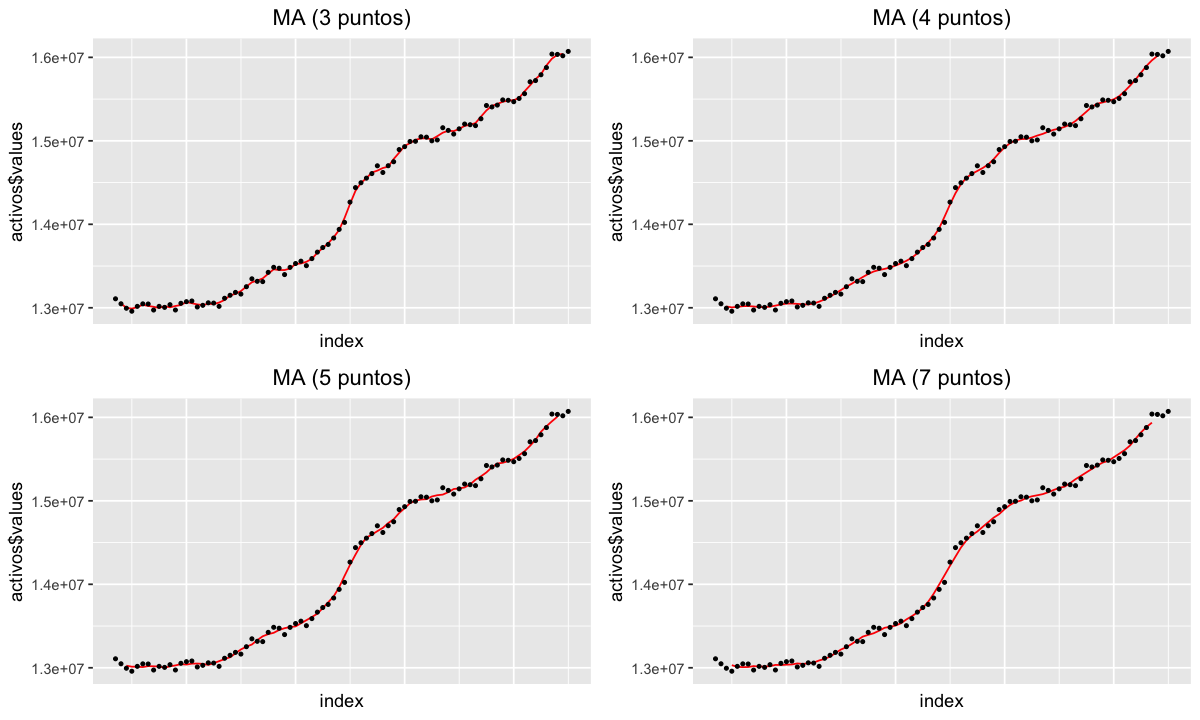

In [36]:
p.a <- ggplot(activos, aes(x = index, y = activos$values)) +
    geom_line(aes(y = as.vector(ma(activos$values,3))), 
              na.rm=TRUE, color = "red") +
    geom_point(size = 0.75) +
    ggtitle("MA (3 puntos)") +
    theme(plot.title = element_text(hjust = 0.5),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank())

p.b <- ggplot(activos, aes(x = index, y = activos$values)) +
    geom_line(aes(y = as.vector(ma(activos$values,4))), 
              na.rm=TRUE, color = "red") +
    geom_point(size = 0.75) +
    ggtitle("MA (4 puntos)") +
    theme(plot.title = element_text(hjust = 0.5),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank())

p.c <- ggplot(activos, aes(x = index, y = activos$values)) +
    geom_line(aes(y = as.vector(ma(activos$values,5))), 
              na.rm=TRUE, color = "red") +
    geom_point(size = 0.75) +
    ggtitle("MA (5 puntos)") +
    theme(plot.title = element_text(hjust = 0.5),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank())

p.d <- ggplot(activos, aes(x = index, y = activos$values)) +
    geom_line(aes(y = as.vector(ma(activos$values,7))), 
              na.rm=TRUE, color = "red") +
    geom_point(size = 0.75) +
    ggtitle("MA (7 puntos)") +
    theme(plot.title = element_text(hjust = 0.5),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank())

cowplot::plot_grid(p.a, p.b, p.c, p.d)

Se probaron medias móviles de 3, 4, 5 y 7 puntos. Tal y como se aprecia en el gráfico, cuanto mayor es el número de puntos de la media móvile, más fácil es apreciar la suavizacion sobre la misma. Para 3 puntos, el suavizado es leve, mientras que para 7, este es muy marcado, eliminando casi por completo la estacionalidad.

## Obtener la descomposición clásica en tendencia y estacionalidad. Dar una valoración de la componente estacional.

En este caso, se ha utilizado una descomposición de carácter aditivo sobre la serie, tal y como se muestra a continuación:

In [37]:
decomposeAndSplit <- function(input.data, frequency, type) {
    d <- decompose(ts(input.data$values, frequency = frequency), type = type)
    output.data <- data.frame(time = 1:nrow(activos),
                              seasonal = d$seasonal, 
                              trend = d$trend, 
                              random = d$random)
    output.data <- melt(output.data ,id.vars = 'time', 
                        variable.name = 'series')
    return(output.data)
}

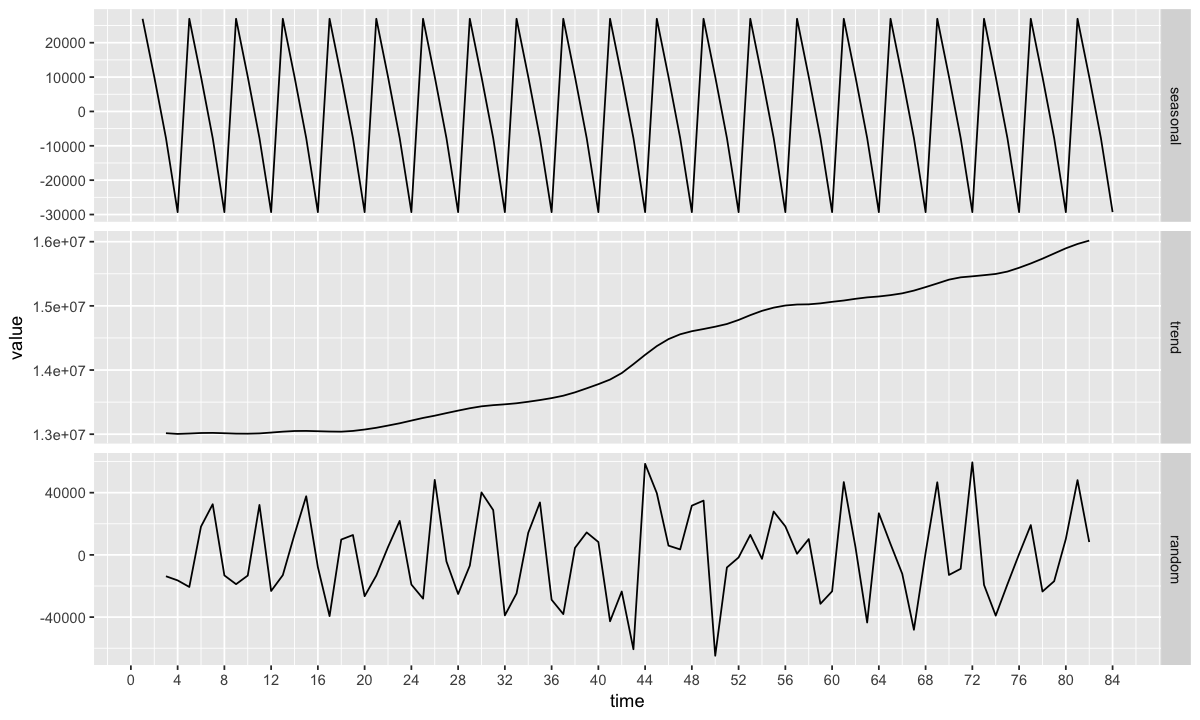

In [38]:
activos.additive <- decomposeAndSplit(activos, frequency = 4, type = "additive")

activos.additive %>%
    ggplot(aes(time,value)) + 
        geom_line(na.rm = TRUE) + 
        scale_x_continuous(breaks = seq(0, 84, by = 4)) +
        facet_grid(series ~ ., scales="free_y")

Tal y como se aprecia en el gráfico las cuatro componentes estacionales (cuatro trimestres) tienen el mismo valor. En el gráfico se observa la repetición de un mismo patrón a lo largo de cada período.

Se ha escogido un modelo aditivo frente al multiplicativo por sencillez, ya que la descomposición que este proporciona respecto del multiplicativo es muy similar, no sabiendo cual de las dos opciones sería más apropiada para esta serie.